In [1]:
import kagglehub

path=kagglehub.dataset_download("alsaniipe/flowers-multiclass-datasets")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flowers-multiclass-datasets


Found 3540 files belonging to 5 classes.
Found 80 files belonging to 5 classes.
Found 50 files belonging to 5 classes.


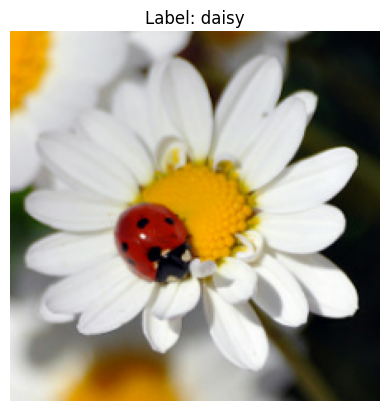

(224, 224, 3)


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

data_dir = '/kaggle/input/flowers-multiclass-datasets/flowers/flowers/flower_photos'


img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
	f"{data_dir}/train",
	image_size=img_size,
	batch_size=batch_size,
	shuffle=True,
	seed=42
)
val_ds = tf.keras.utils.image_dataset_from_directory(
	f"{data_dir}/validation",
	image_size=img_size,
	batch_size=batch_size,
	shuffle=True,
	seed=42
)
test_ds = tf.keras.utils.image_dataset_from_directory(
	f"{data_dir}/test",
	image_size=img_size,
	batch_size=batch_size,
	shuffle=False
)

class_names = train_ds.class_names

# Show one image and label
for images, labels in train_ds.take(1):
	img = images[0].numpy().astype("uint8")
	label = labels[0].numpy()
	plt.imshow(img)
	plt.title(f"Label: {class_names[label]}")
	plt.axis('off')
	plt.show()
	print(img.shape)


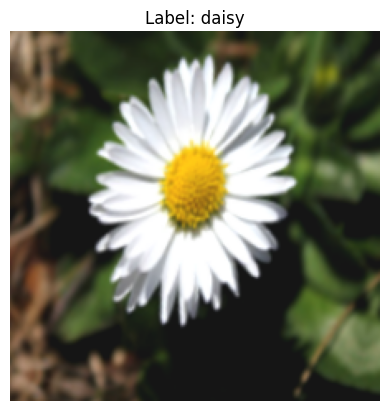

(224, 224, 3)


In [3]:


# Define data augmentation pipeline using tf.keras
data_augmentation = keras.Sequential([
	layers.RandomRotation(0.111),  # ~20 degrees in radians
	layers.RandomFlip("horizontal"),
	layers.RandomTranslation(0.1, 0.1),
	layers.RandomCrop(200, 200),
	layers.RandomContrast(0.3),
	layers.RandomBrightness(0.2),
	layers.Resizing(224, 224),
])

# Visualize one augmented image from train_ds
for images, labels in train_ds.take(1):
	augmented_img = data_augmentation(images)[0].numpy().astype("uint8")
	label = labels[0].numpy()
	plt.imshow(augmented_img)
	plt.title(f"Label: {class_names[label]}")
	plt.axis('off')
	plt.show()
	print(augmented_img.shape)


In [4]:
def one_hot_encode_dataset(dataset, num_classes):
	return dataset.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

num_classes = len(class_names)
train_onehot_ds = one_hot_encode_dataset(train_ds, num_classes)
val_onehot_ds = one_hot_encode_dataset(val_ds, num_classes)
test_onehot_ds = one_hot_encode_dataset(test_ds, num_classes)

# for images, labels in train_onehot_ds.take(1):
# 	print(labels[0].shape)


In [5]:
import matplotlib.pyplot as plt
def plot_val_loss_accuracy(history):

  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Val Accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def process_predictions(model:models,val_ds):
    y_true = []
    y_pred = []

    for x_batch, y_batch in val_ds:
        preds = model.predict(x_batch)
        y_true.append(y_batch.numpy())
        y_pred.append(preds)

    # Convert to full arrays
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Convert from one-hot to integer labels
    y_true_int = np.argmax(y_true, axis=1)
    y_pred_int = np.argmax(y_pred, axis=1)
    return y_true_int,y_pred_int,y_true,y_pred
def print_confusion_matrix(model:models, val_ds, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
def display_ROC_curve(model:models, val_ds, y_true, y_pred):
    n_classes = y_true.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    for i in range(n_classes):
      print(f"AUC for class {i}: {roc_auc[i]:.4f}")

def display_final_results(model:models,history,val_ds,):
  plot_val_loss_accuracy(history)
  val_loss, val_acc, val_f1, val_precision, val_recall = model.evaluate(val_ds, verbose = 0)
  evaluate_result(model,val_ds)
  y_true_int, y_pred_int, y_true, y_pred = process_predictions(model, val_ds)
  print_confusion_matrix(model, val_ds, y_true_int, y_pred_int)
  display_ROC_curve(model, val_ds, y_true, y_pred)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 143s 928ms/step - accuracy: 0.2720 - loss: 1.7411 - val_accuracy: 0.3625 - val_loss: 1.4401
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 59s 498ms/step - accuracy: 0.4408 - loss: 1.2672 - val_accuracy: 0.6125 - val_loss: 0.9735
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 82s 500ms/step - accuracy: 0.5558 - loss: 1.0869 - val_accuracy: 0.6500 - val_loss: 0.9159
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 54s 490ms/step - accuracy: 0.6398 - loss: 0.9407 - val_accuracy: 0.7000 - val_loss: 0.8205
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 83s 495ms/step - accuracy: 0.6922 - loss: 0.8042 - val_accuracy: 0.6625 - val_loss: 0.8665
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 82s 499ms/step - accuracy: 0.6976 - loss: 0.7550 - val_accuracy: 0.7250 - val_loss: 0.8042
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 81s 494ms/step - accuracy: 0.7496 - loss: 0.6479 - val_accuracy: 0.6500 - val_loss: 0.8983
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 82s 499ms/step - accuracy: 0.7655 - loss: 

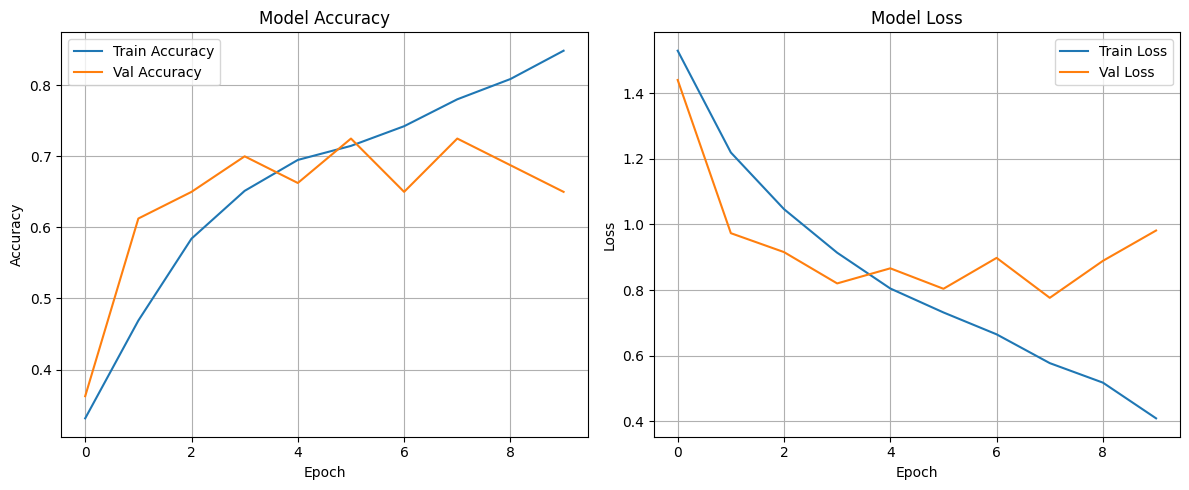

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7219 - loss: 0.8182
Validation Loss     : 0.7766
Validation Accuracy : 72.50%


In [7]:

model = models.Sequential([
	layers.Input(shape=(224, 224, 3)),
	# Block 1
	layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
	layers.MaxPooling2D((2, 2)),
	# Block 2
	layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
	layers.MaxPooling2D((2, 2)),
	# Block 3
	layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
	layers.MaxPooling2D((2, 2)),
	# Block 4
	layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
	layers.MaxPooling2D((2, 2)),
	# Block 5
	layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
	layers.MaxPooling2D((2, 2)),
	layers.Flatten(),
	layers.Dense(4096, activation='relu'),
	layers.Dropout(0.5),
	layers.Dense(4096, activation='relu'),
  layers.Dense(5, activation='softmax')
])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']

)

history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=10,
	callbacks=[early_stop]
)
plot_val_loss_accuracy(history)
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Loss     : {val_loss:.4f}")
print(f"Validation Accuracy : {val_acc:.2%}")

In [8]:


def f1_score(y_true, y_pred):
    y_pred_labels = tf.one_hot(tf.argmax(y_pred, axis=-1), depth=tf.shape(y_pred)[-1])

    y_true = K.cast(y_true, 'float32')
    y_pred_labels = K.cast(y_pred_labels, 'float32')

    tp = K.sum(y_true * y_pred_labels)
    fp = K.sum((1 - y_true) * y_pred_labels)
    fn = K.sum(y_true * (1 - y_pred_labels))

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2 * (precision * recall) / (precision + recall + K.epsilon())


In [9]:
def evaluate_result(model:models,validation_ds):
  val_loss, val_acc, val_f1, val_precision, val_recall = model.evaluate(validation_ds)
  print(f"Validation Loss     : {val_loss:.4f}")
  print(f"Validation Accuracy : {val_acc:.2%}")
  print(f"Validation F1-score : {val_f1:.4f}")
  print(f"Validation Precision: {val_precision:.4f}")
  print(f"Validation Recall   : {val_recall:.4f}")


In [11]:
model_one_hot = models.Sequential([
	layers.Input(shape=(224, 224, 3)),
	# Block 1
	layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
	layers.MaxPooling2D((2, 2)),
	# Block 2
	layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
	layers.MaxPooling2D((2, 2)),
	# Block 3
	layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
	layers.MaxPooling2D((2, 2)),
	# Block 4
	layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
	layers.MaxPooling2D((2, 2)),
	# Block 5
	layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
	layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
	layers.MaxPooling2D((2, 2)),
	layers.Flatten(),
	layers.Dense(4096, activation='relu'),
	layers.Dropout(0.5),
	layers.Dense(4096, activation='relu'),
  layers.Dense(5, activation='softmax')
])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

model_one_hot.compile(
	optimizer=optimizers.Adam(learning_rate=1e-4),
	loss='categorical_crossentropy',
	metrics=['accuracy'
	        ,f1_score,
					metrics.Precision(name='precision'),
        	metrics.Recall(name='recall')]

)

history = model_one_hot.fit(
	train_onehot_ds,
	validation_data=val_onehot_ds,
	epochs=10,
	callbacks=[early_stop]
)


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 74s 571ms/step - accuracy: 0.2719 - f1_score: 0.2719 - loss: 1.6096 - precision: 0.3138 - recall: 0.0302 - val_accuracy: 0.5375 - val_f1_score: 0.5625 - val_loss: 1.1577 - val_precision: 0.5952 - val_recall: 0.3125
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 71s 508ms/step - accuracy: 0.4410 - f1_score: 0.4410 - loss: 1.2687 - precision: 0.5553 - recall: 0.1818 - val_accuracy: 0.5000 - val_f1_score: 0.5104 - val_loss: 1.0892 - val_precision: 0.6452 - val_recall: 0.2500
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 82s 508ms/step - accuracy: 0.5197 - f1_score: 0.5197 - loss: 1.0972 - precision: 0.6276 - recall: 0.3315 - val_accuracy: 0.5875 - val_f1_score: 0.5625 - val_loss: 0.9417 - val_precision: 0.7333 - val_recall: 0.4125
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 55s 500ms/step - accuracy: 0.6249 - f1_score: 0.6249 - loss: 0.9580 - precision: 0.7174 - recall: 0.4761 - val_accuracy: 0.6625 - val_f1_score: 0.6458 - val_loss: 0.8493 - val_precision: 0.7778 -

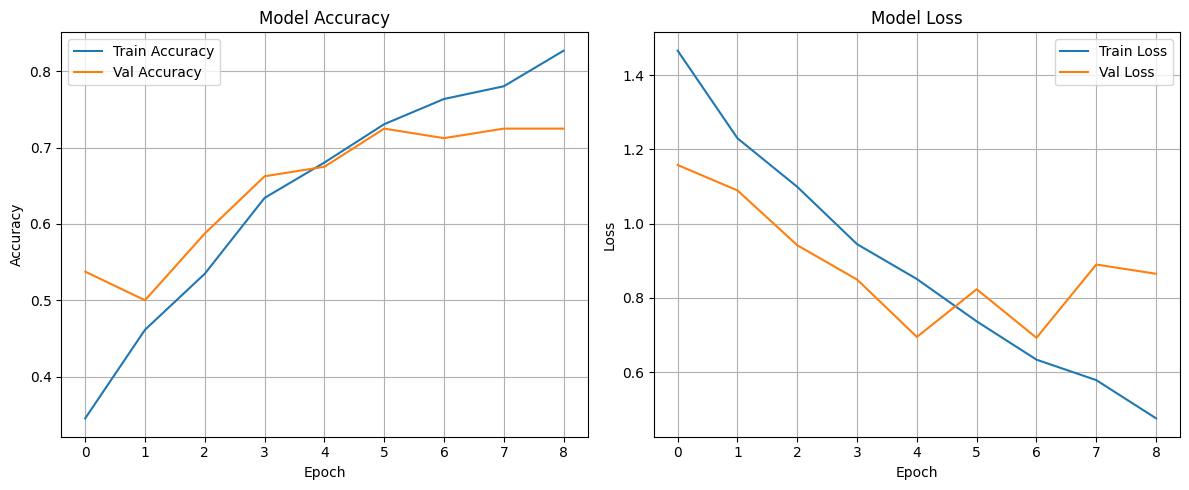

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.7039 - f1_score: 0.7070 - loss: 0.6849 - precision: 0.7894 - recall: 0.6797
Validation Loss     : 0.6926
Validation Accuracy : 71.25%
Validation F1-score : 0.7187
Validation Precision: 0.7971
Validation Recall   : 0.6875
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


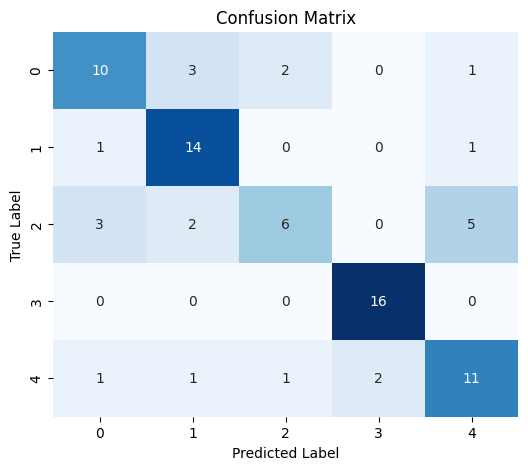

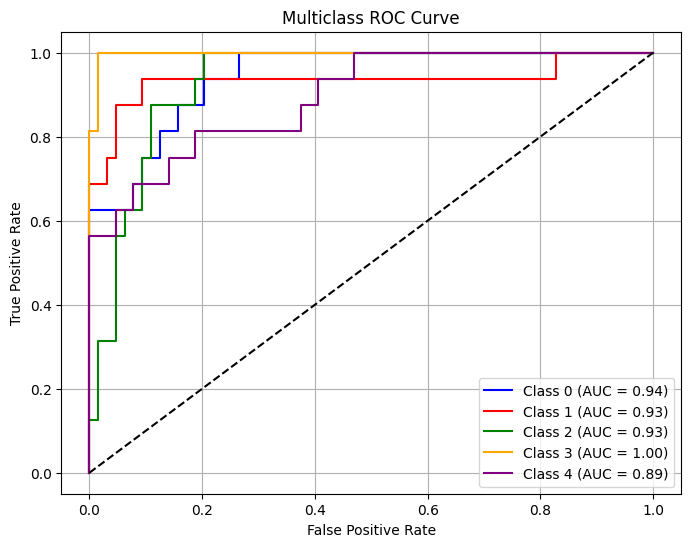

AUC for class 0: 0.9424
AUC for class 1: 0.9346
AUC for class 2: 0.9316
AUC for class 3: 0.9971
AUC for class 4: 0.8936


In [12]:
display_final_results(model_one_hot,history,val_onehot_ds)

In [13]:
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False
fine_tuned_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

fine_tuned_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'
    ,f1_score,
		metrics.Precision(name='precision'),
    metrics.Recall(name='recall')]

)

fine_tuned_history = fine_tuned_model.fit(
    train_onehot_ds,
    validation_data=val_onehot_ds,
    epochs=10,
    callbacks=[early_stop]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 43s 227ms/step - accuracy: 0.4764 - f1_score: 0.4764 - loss: 1.5034 - precision: 0.5467 - recall: 0.3852 - val_accuracy: 0.7875 - val_f1_score: 0.7604 - val_loss: 0.6607 - val_precision: 0.9104 - val_recall: 0.7625
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.7951 - f1_score: 0.7950 - loss: 0.5754 - precision: 0.8573 - recall: 0.7426 - val_accuracy: 0.8250 - val_f1_score: 0.8229 - val_loss: 0.5521 - val_precision: 0.9118 - val_recall: 0.7750
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.8370 - f1_score: 0.8370 - loss: 0.4643 - precision: 0.8850 - recall: 0.7934 - val_accuracy: 0.8375 - val_f1_score: 0.8333 - val_loss: 0.5083 - val_precision: 0.9155 - val_recall: 0.8125
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.8627 - f1_score: 0.8627 - loss: 0.3883 - precision: 0.9028 - recall: 0.8256 - val_accuracy: 0.8375 - val_f1_score: 0.8

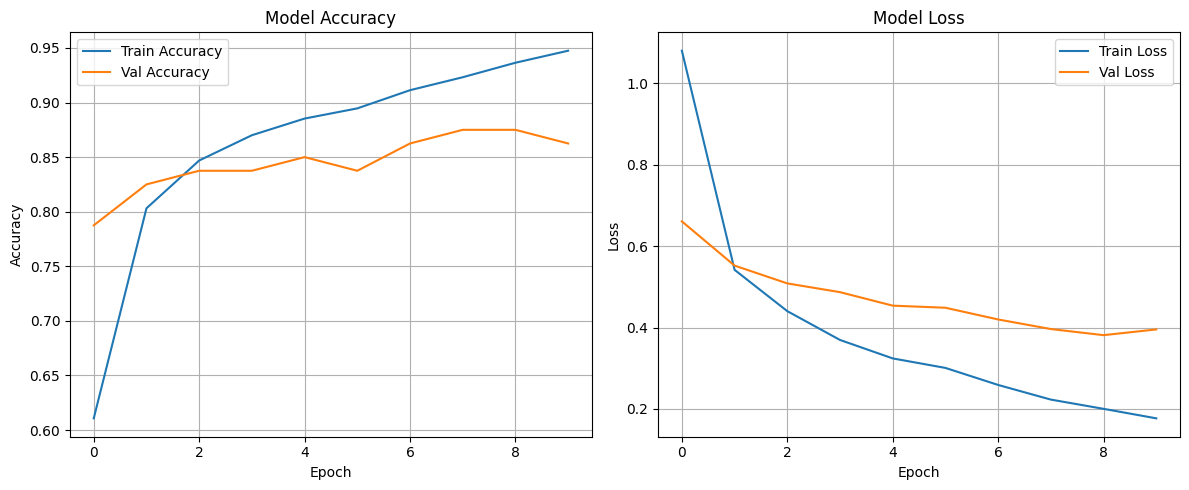

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9023 - f1_score: 0.8971 - loss: 0.3117 - precision: 0.9407 - recall: 0.8742
Validation Loss     : 0.3812
Validation Accuracy : 87.50%
Validation F1-score : 0.8646
Validation Precision: 0.9315
Validation Recall   : 0.8500
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


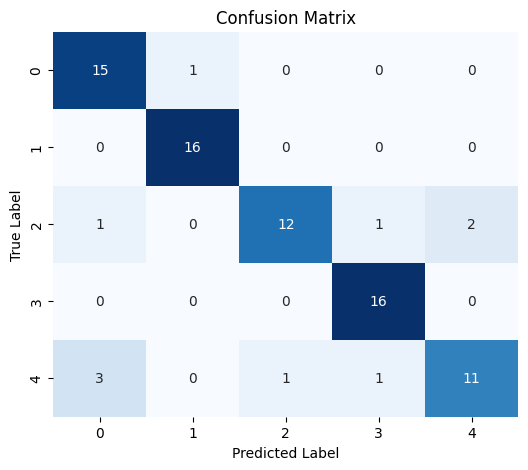

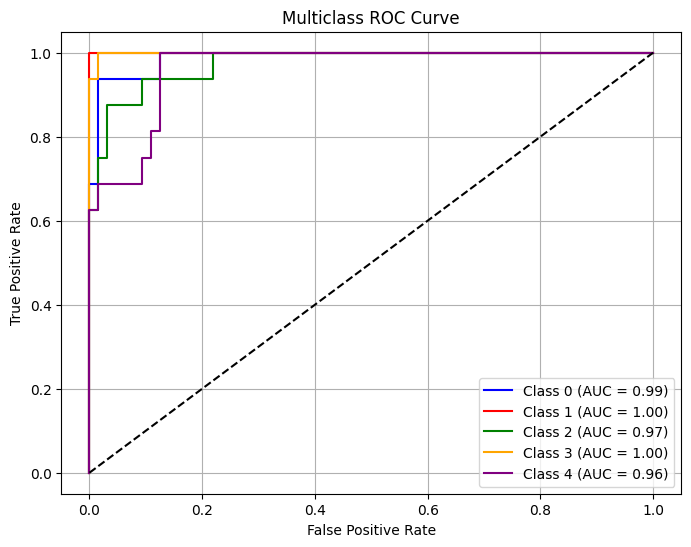

AUC for class 0: 0.9883
AUC for class 1: 1.0000
AUC for class 2: 0.9746
AUC for class 3: 0.9990
AUC for class 4: 0.9629


In [14]:
display_final_results(fine_tuned_model,fine_tuned_history,val_onehot_ds)

In [16]:
for layer in base_model.layers:
    if layer.name.startswith('conv5_block'):
        layer.trainable = True

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
fine_tuned_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'
            ,f1_score,
					  metrics.Precision(name='precision'),
        	  metrics.Recall(name='recall')])

fine_tuned_history = fine_tuned_model.fit(
          train_onehot_ds,
          validation_data=val_onehot_ds,
          epochs=10,
          callbacks=[early_stop]
)



Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 108s 264ms/step - accuracy: 0.8359 - f1_score: 0.8359 - loss: 0.4649 - precision: 0.8674 - recall: 0.7995 - val_accuracy: 0.8625 - val_f1_score: 0.8646 - val_loss: 0.4038 - val_precision: 0.8816 - val_recall: 0.8375
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 17s 130ms/step - accuracy: 0.9203 - f1_score: 0.9203 - loss: 0.2396 - precision: 0.9469 - recall: 0.8968 - val_accuracy: 0.8625 - val_f1_score: 0.8750 - val_loss: 0.3532 - val_precision: 0.9054 - val_recall: 0.8375
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9554 - f1_score: 0.9554 - loss: 0.1581 - precision: 0.9717 - recall: 0.9349 - val_accuracy: 0.8750 - val_f1_score: 0.8750 - val_loss: 0.3344 - val_precision: 0.9079 - val_recall: 0.8625
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9624 - f1_score: 0.9624 - loss: 0.1256 - precision: 0.9733 - recall: 0.9513 - val_accuracy: 0.8750 - val_f1_score: 0.8750 - val_loss: 0.3278 - val_precision: 0.9333 

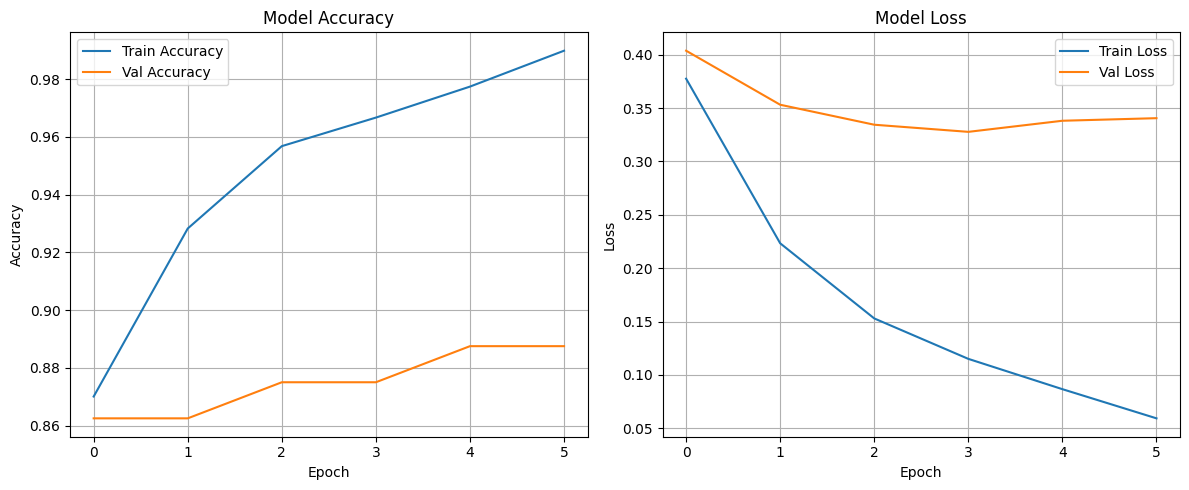

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8750 - f1_score: 0.8750 - loss: 0.3202 - precision: 0.9258 - recall: 0.8750
Validation Loss     : 0.3278
Validation Accuracy : 87.50%
Validation F1-score : 0.8750
Validation Precision: 0.9333
Validation Recall   : 0.8750


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


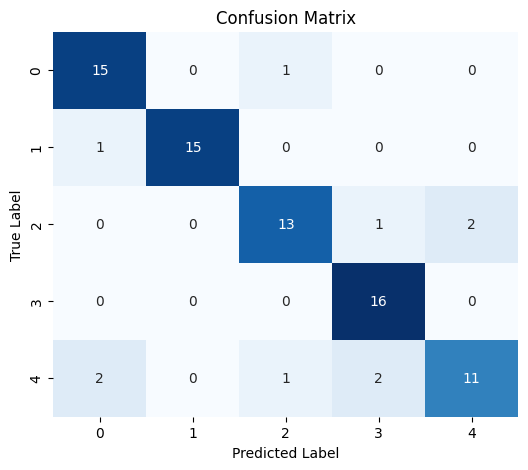

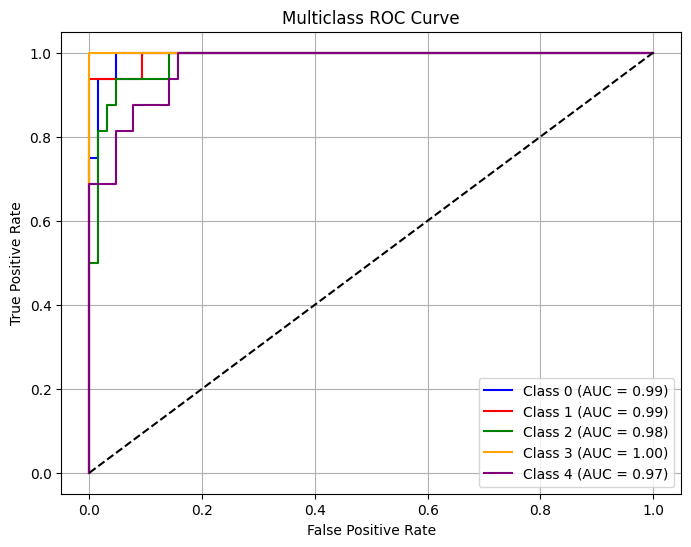

AUC for class 0: 0.9941
AUC for class 1: 0.9941
AUC for class 2: 0.9814
AUC for class 3: 1.0000
AUC for class 4: 0.9707


In [17]:
display_final_results(fine_tuned_model,fine_tuned_history,val_onehot_ds)

In [18]:
base_model.trainable = True
fine_tuned_model.trainable = True

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
fine_tuned_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'
            ,f1_score,
					  metrics.Precision(name='precision'),
        	  metrics.Recall(name='recall')])

fine_tuned_history = fine_tuned_model.fit(
          train_onehot_ds,
          validation_data=val_onehot_ds,
          epochs = 10,
          callbacks=[early_stop]
)


Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 146s 627ms/step - accuracy: 0.9154 - f1_score: 0.9154 - loss: 0.2416 - precision: 0.9328 - recall: 0.8988 - val_accuracy: 0.8750 - val_f1_score: 0.8437 - val_loss: 0.3740 - val_precision: 0.8846 - val_recall: 0.8625
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 296ms/step - accuracy: 0.9637 - f1_score: 0.9637 - loss: 0.1118 - precision: 0.9777 - recall: 0.9546 - val_accuracy: 0.9000 - val_f1_score: 0.9062 - val_loss: 0.3166 - val_precision: 0.8974 - val_recall: 0.8750
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 34s 307ms/step - accuracy: 0.9770 - f1_score: 0.9770 - loss: 0.0679 - precision: 0.9816 - recall: 0.9750 - val_accuracy: 0.9125 - val_f1_score: 0.9167 - val_loss: 0.3298 - val_precision: 0.9091 - val_recall: 0.8750
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 294ms/step - accuracy: 0.9864 - f1_score: 0.9864 - loss: 0.0458 - precision: 0.9890 - recall: 0.9837 - val_accuracy: 0.9125 - val_f1_score: 0.9271 - val_loss: 0.3263 - val_precision: 0.9114 

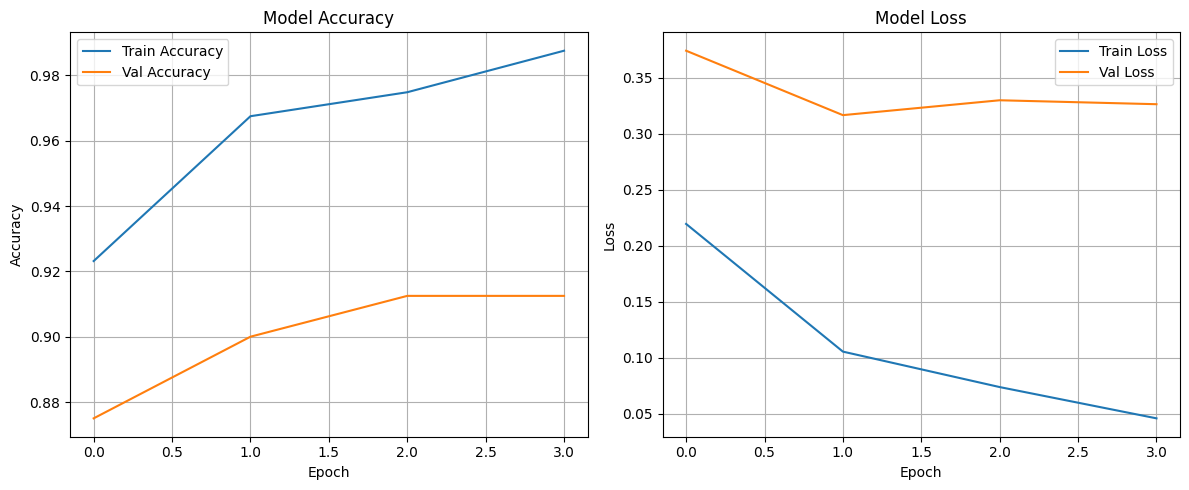

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8836 - f1_score: 0.8867 - loss: 0.3658 - precision: 0.8802 - recall: 0.8555
Validation Loss     : 0.3166
Validation Accuracy : 90.00%
Validation F1-score : 0.9062
Validation Precision: 0.8974
Validation Recall   : 0.8750
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


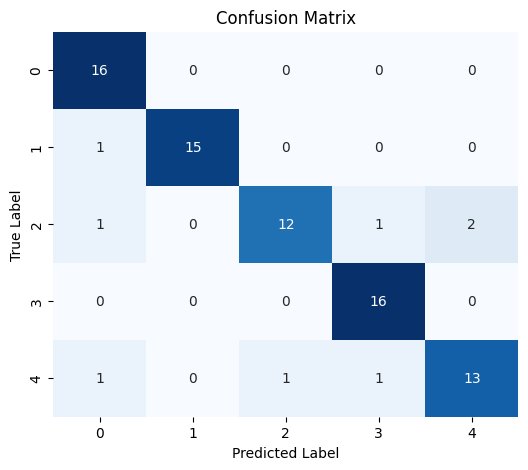

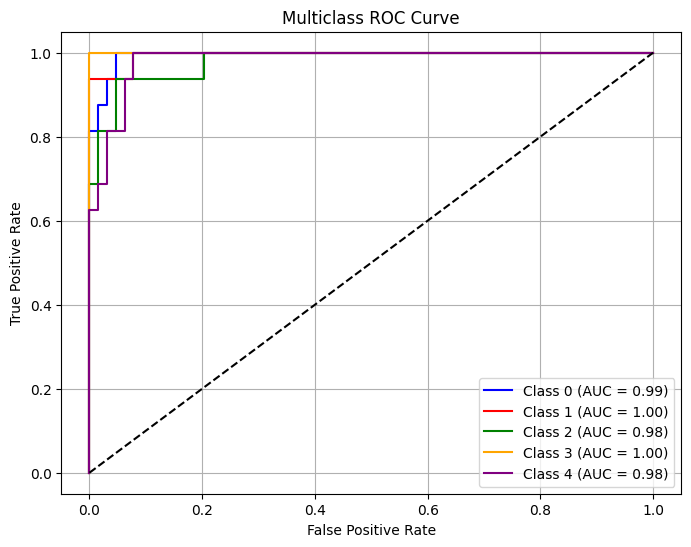

AUC for class 0: 0.9941
AUC for class 1: 0.9951
AUC for class 2: 0.9795
AUC for class 3: 1.0000
AUC for class 4: 0.9824


In [19]:
display_final_results(fine_tuned_model,fine_tuned_history,val_onehot_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8783 - f1_score: 0.8796 - loss: 0.3692 - precision: 0.9210 - recall: 0.8650 
Validation Loss     : 0.4412
Validation Accuracy : 88.00%
Validation F1-score : 0.8819
Validation Precision: 0.9149
Validation Recall   : 0.8600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


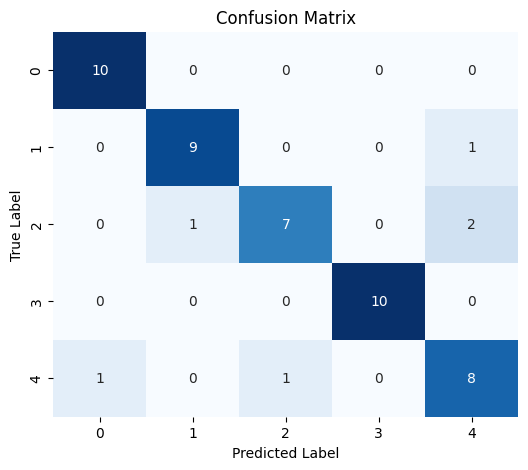

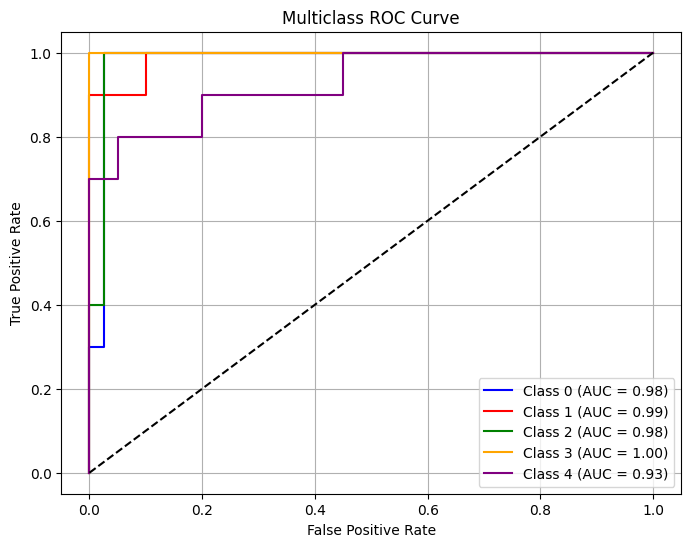

AUC for class 0: 0.9825
AUC for class 1: 0.9900
AUC for class 2: 0.9850
AUC for class 3: 1.0000
AUC for class 4: 0.9300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.6883 - f1_score: 0.7130 - loss: 0.8725 - precision: 0.8194 - recall: 0.6008
Validation Loss     : 0.8029
Validation Accuracy : 72.00%
Validation F1-score : 0.7569
Validation Precision: 0.8378
Validation Recall   : 0.6200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


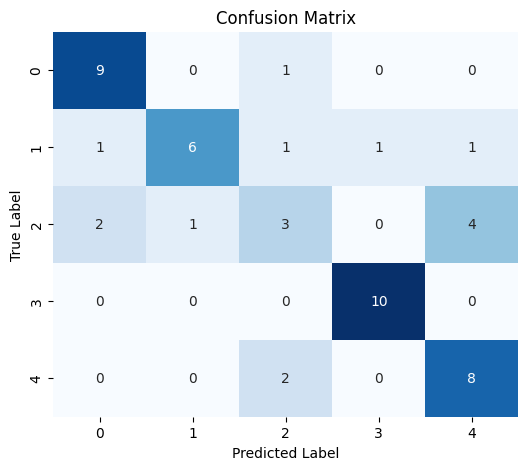

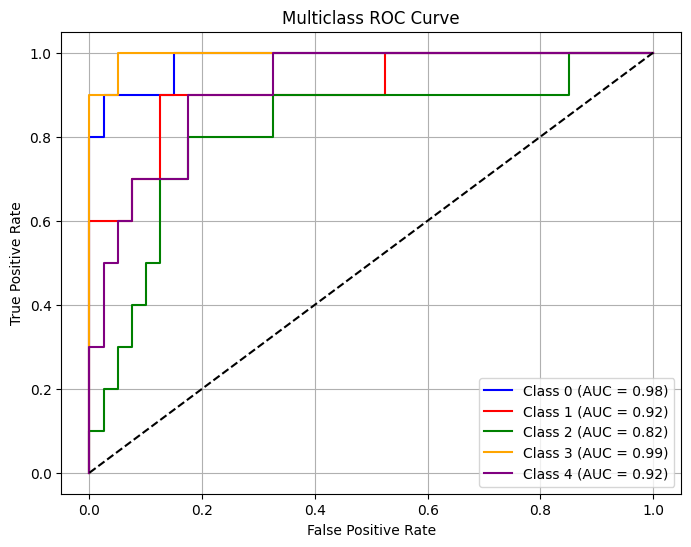

AUC for class 0: 0.9825
AUC for class 1: 0.9150
AUC for class 2: 0.8150
AUC for class 3: 0.9950
AUC for class 4: 0.9150


In [21]:
##Final Test data result:

# display_final_results(fine_tuned_model,fine_tuned_history,test_onehot_ds)
val_loss, val_acc, val_f1, val_precision, val_recall = fine_tuned_model.evaluate(test_onehot_ds, verbose = 0)
evaluate_result(fine_tuned_model,test_onehot_ds)
y_true_int, y_pred_int, y_true, y_pred = process_predictions(fine_tuned_model, test_onehot_ds)
print_confusion_matrix(fine_tuned_model, test_onehot_ds, y_true_int, y_pred_int)
display_ROC_curve(fine_tuned_model, test_onehot_ds, y_true, y_pred)

# display_final_results(model_one_hot,history,test_onehot_ds)

val_loss, val_acc, val_f1, val_precision, val_recall = model_one_hot.evaluate(test_onehot_ds, verbose = 0)
evaluate_result(model_one_hot,test_onehot_ds)
y_true_int, y_pred_int, y_true, y_pred = process_predictions(model_one_hot, test_onehot_ds)
print_confusion_matrix(model_one_hot, test_onehot_ds, y_true_int, y_pred_int)
display_ROC_curve(model_one_hot, test_onehot_ds, y_true, y_pred)


# Bonus Question 2:
**A**: each filter have 2*2 weights for each channel.We have 3 color channels. And there is a bias for each filter. So there is 2 * 2 * 3 + 1 = 13 in a filter. There are 3 filters in each layer. So we have 39 total learnable parameter for each layer.

**B**: If we wanted to have the same output as the convloutional layer we should have 27 * 27 * 3 nodes at the second layer (Considering 1 stride for the filter). And then for the input layer, number of nodes should match the flattend size of the input image (That is 28 * 28 *3)
So the number of parameters between these two layers will be:
  
$27 * 27 * 3 *  28 * 28 * 3 + 27 * 27 *3 = $

$ 2187 * 2352  + 2352 = 5,146,011$

